In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

from statsmodels.discrete.discrete_model import Logit
from scipy.special import expit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

In [4]:
# Predictor
n_obs = 100
x_mean = 0
x_sd = 3
x = rng.normal(x_mean, x_sd, n_obs)
xarray = xr.DataArray(x, dims = ["plot_dim"])

# Relationship & link function
true_intercept = -2 # Value of logit(y) when X is zero. 0 corresponds to p = 0.5.
true_slope = 1 # Change in logit(y) when X changes by 1. The odds ratio of y (p / 1-p) is multiplied by exp(slope) when X changes by 1. The odds ratio changes by (exp(slope) - 1)%.
true_logits = true_intercept + (true_slope * x) # When the logit is 0, p = 0.5.
true_probs = expit(true_logits) # Conditional mean as a function of the linear predictor with logit link.

# Target
y = rng.binomial(n = 1, p = true_probs, size = n_obs) # Prob. of success as a function of the linear predictor with logit link.
noise = y - true_probs # Variance in probabilities

In [5]:
# "Default" probability with this intercept value:
expit(true_intercept)

0.11920292202211755

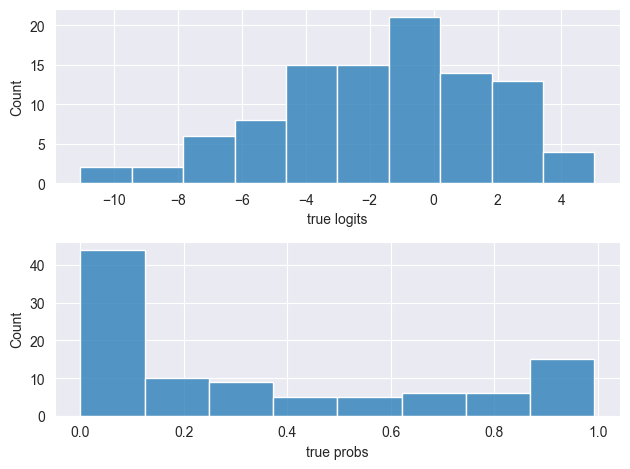

In [6]:
# Distributions of logits & probs
fig, ax = plt.subplots(2)

_ = sns.histplot(true_logits, ax = ax[0])
_ = ax[0].set_xlabel("true logits")

_ = sns.histplot(true_probs, ax = ax[1])
_ = ax[1].set_xlabel("true probs")

As the true slope increases, the distribution of true probabilities becomes more U-shaped.

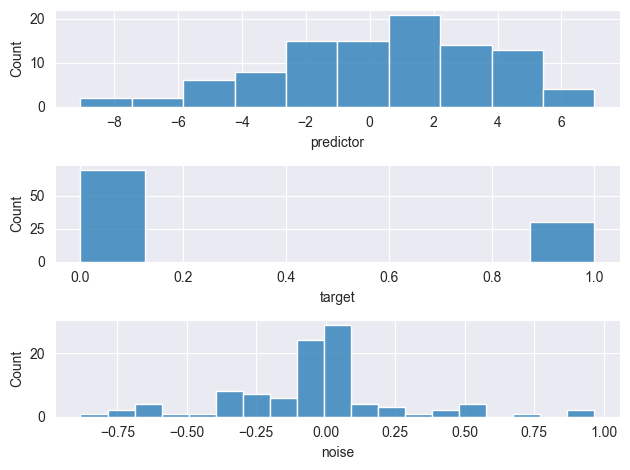

In [7]:
# Distributions of data
fig, ax = plt.subplots(3)

_ = sns.histplot(x, ax = ax[0])
_ = ax[0].set_xlabel("predictor")

_ = sns.histplot(y, ax = ax[1])
_ = ax[1].set_xlabel("target")

_ = sns.histplot(noise, ax = ax[2])
_ = ax[2].set_xlabel("noise")

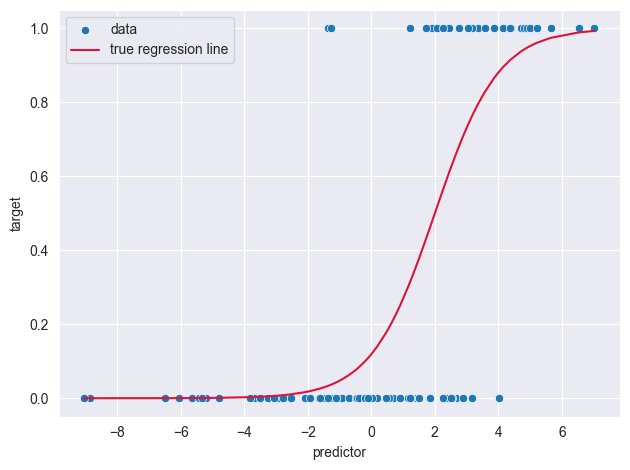

In [8]:
# True regression line
_ = sns.scatterplot(x = x, y = y, label = "data")
_ = sns.lineplot(x = x, y = true_probs, label = "true regression line", color = "crimson")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

Higher x slope results in a stronger predictive relationship, and a steeper regression line: More observations are pushed to p = 0 or 1.

An intercept of 0 corresponds to p = 0.5 when x = 0. A large absolute value for the intercept pushes more observations towards p = 0 or p = 1.

## Frequentist Logistic regression

In [9]:
constant = np.ones(n_obs)
exog = np.stack([x, constant]).transpose()

In [10]:
lr = Logit(endog = y, exog = exog)

In [11]:
lr_res = lr.fit()
lr_fitted = lr.predict(lr_res.params, exog)

Optimization terminated successfully.
         Current function value: 0.307939
         Iterations 8


In [12]:
lr_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Wed, 17 Jan 2024   Pseudo R-squ.:                  0.4959
Time:                        15:27:11   Log-Likelihood:                -30.794
converged:                       True   LL-Null:                       -61.086
Covariance Type:            nonrobust   LLR p-value:                 7.047e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0009      0.212      4.724      0.000       0.586       1.416
const         -2.4435      0.537     -4.549      0.000      -3.496      -1.391
==============================================================================
"""

Point estimates for model coefficients are not bad.

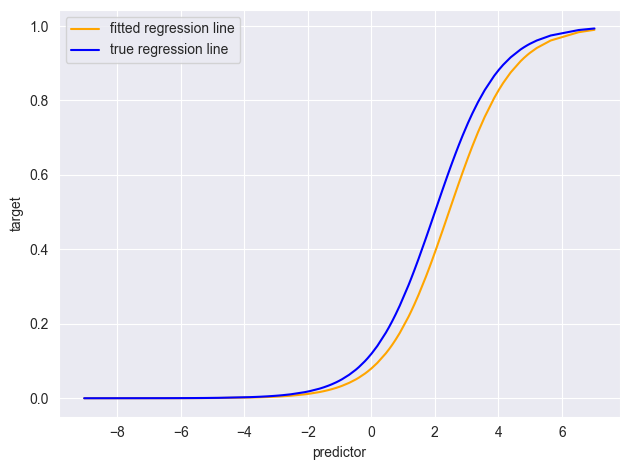

In [13]:
_ = sns.lineplot(
    x = x, 
    y = lr_fitted, 
    label = "fitted regression line", color = "orange")
_ = sns.lineplot(
    x = x, 
    y = true_probs, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

## Flat prior

In [14]:
# Create model
flat_model = pm.Model()

In [15]:
# Define priors & likelihood
with flat_model:

    # Flat priors for all parameters
    intercept = pm.Normal("intercept", mu = 0, sigma = 1) 
    slope = pm.Normal("slope", mu = 0, sigma = 1)

    # Expected value & link
    logit = intercept + slope * x
    prob = pm.math.invlogit(logit)

    # Likelihood
    likelihood = pm.Bernoulli("outcome", p = prob, observed = y)

In [16]:
# Sample from the prior
with flat_model:
    flat_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


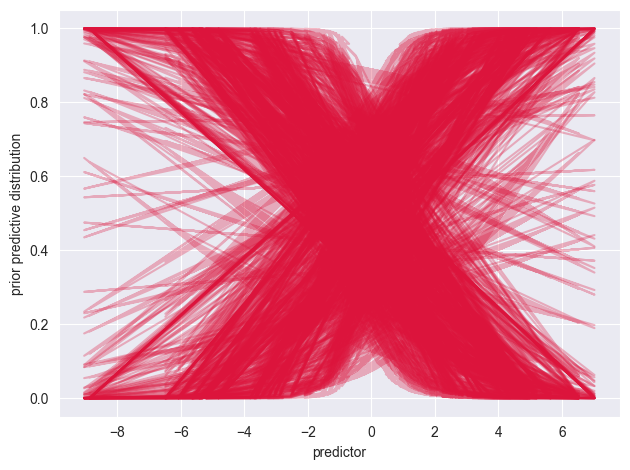

In [17]:
# Prior predictive check
y_flat_prior = expit(flat_prior.prior["intercept"] + (flat_prior.prior["slope"] * xarray))
y_flat_prior = y_flat_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_flat_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

The flat prior allows for the correct domain (0, 1) but doesn't restrict the regression line at all.

In [18]:
# Draw posterior samples
with flat_model:
    flat_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [19]:
# Sample from posterior
with flat_model:
    pm.sample_posterior_predictive(flat_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


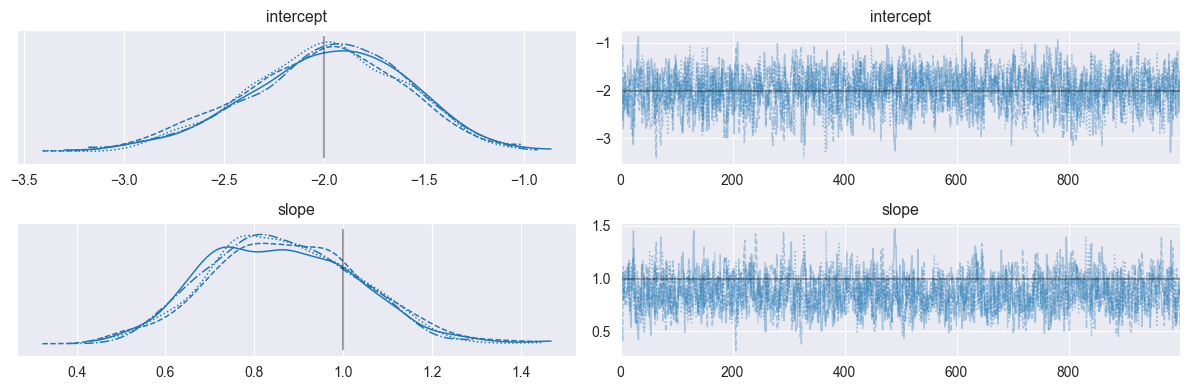

In [20]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    flat_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

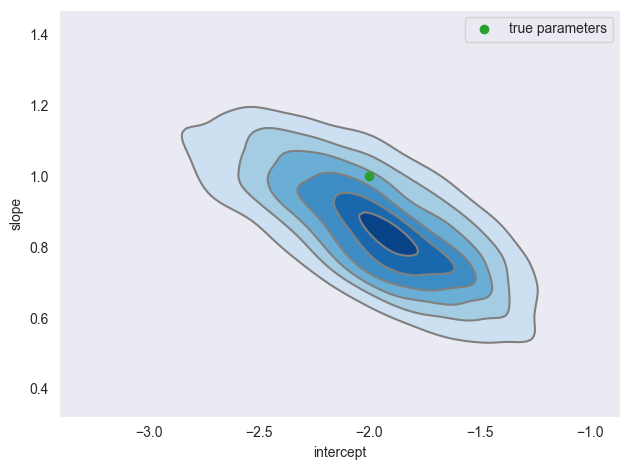

In [21]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(flat_posterior, var_names="intercept"),
    az.extract(flat_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

Comparable parameter estimates with frequentist logistic regression.

In [22]:
# Simulate fitted regression lines
flat_posterior.posterior["fitted"] = expit(flat_posterior.posterior["intercept"] + flat_posterior.posterior["slope"] * xarray)

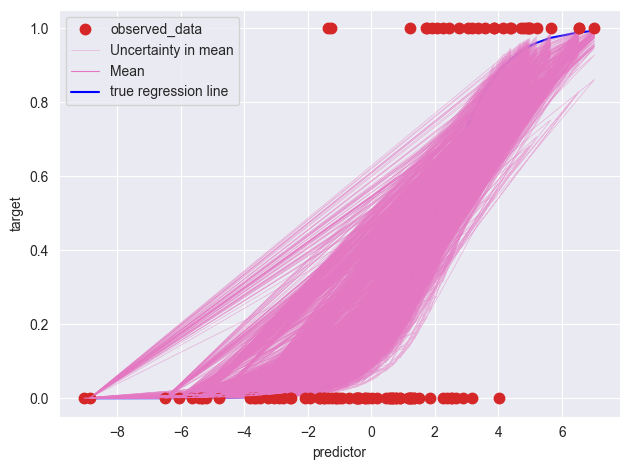

In [23]:
# Plot regression lines
_ = az.plot_lm(
    idata = flat_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_probs, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


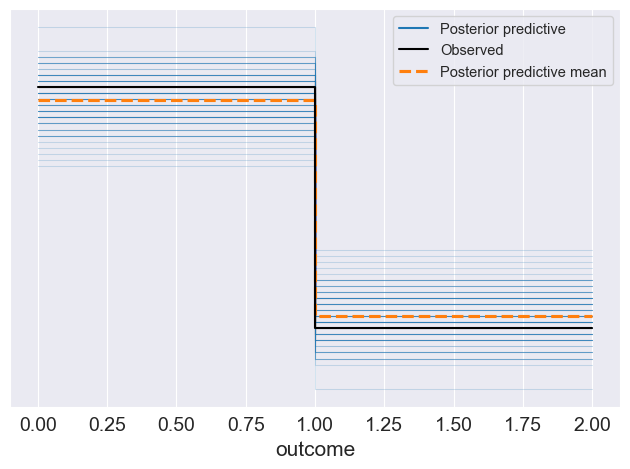

In [24]:
# Plot posterior distribution
_ = az.plot_ppc(flat_posterior, num_pp_samples = 100)

Fitted relationship & posterior predictive distribution is pretty decent for flat priors.

## Weakly Informative Prior

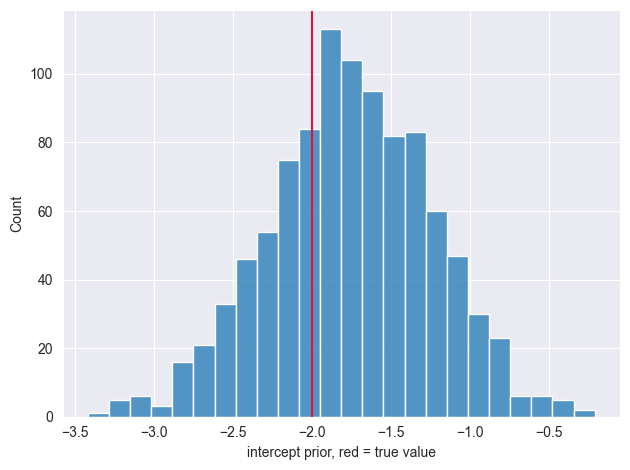

In [25]:
# Tune the intercept prior
prior_intercept_mu = -1.75
prior_intercept_sd = 0.5
_ = sns.histplot(rng.normal(prior_intercept_mu, prior_intercept_sd, size = 1000))
_ = plt.axvline(true_intercept, c = "crimson")
_ = plt.xlabel("intercept prior, red = true value")

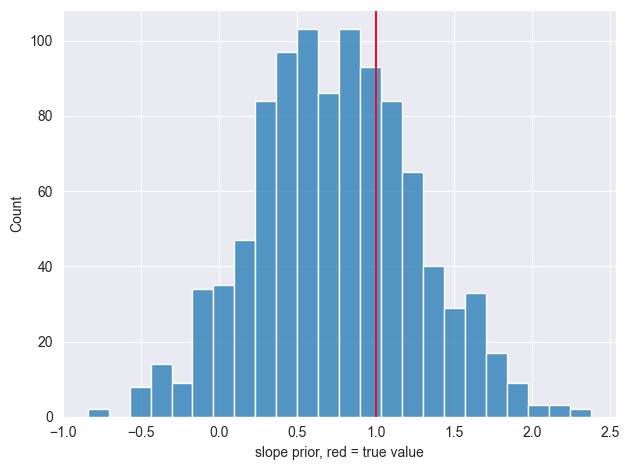

In [26]:
# Tune the slope prior
prior_slope_mu = 0.75
prior_slope_sd = 0.5
_ = sns.histplot(rng.normal(prior_slope_mu, prior_slope_sd, size = 1000))
_ = plt.axvline(true_slope, c = "crimson")
_ = plt.xlabel("slope prior, red = true value")

In [27]:
# Create model
informative_model = pm.Model()

In [28]:
# Define priors & likelihood
with informative_model:

    # Informative priors for all parameters
    intercept = pm.Normal("intercept", mu = prior_intercept_mu, sigma = prior_intercept_sd)
    slope = pm.Normal("slope", mu = prior_slope_mu, sigma = prior_slope_sd)

    # Expected value & link
    logit = intercept + slope * x
    prob = pm.invlogit(logit)

    # Likelihood
    likelihood = pm.Bernoulli("outcome", p = prob, observed = y)

In [29]:
# Sample from the prior
with informative_model:
    informative_prior = pm.sample_prior_predictive(
        samples = n_obs,
        var_names = ["intercept", "slope"],
        random_seed = rng)

Sampling: [intercept, slope]


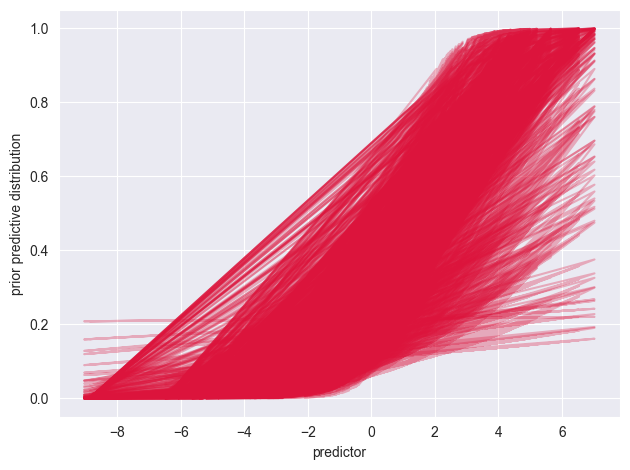

In [30]:
# Prior predictive check
y_informative_prior = expit(informative_prior.prior["intercept"] + (informative_prior.prior["slope"] * xarray))
y_informative_prior = y_informative_prior.stack(sample=("chain", "draw"))

_ = plt.plot(xarray, y_informative_prior, color = "crimson", alpha = 0.3)
_ = plt.xlabel("predictor")
_ = plt.ylabel("prior predictive distribution")

Much more sensical prior compared to flat, but still allows some lopsided regression lines.

In [31]:
# Draw posterior samples
with informative_model:
    informative_posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [32]:
# Sample from posterior
with informative_model:
    pm.sample_posterior_predictive(informative_posterior, extend_inferencedata = True, random_seed = rng)

Sampling: [outcome]


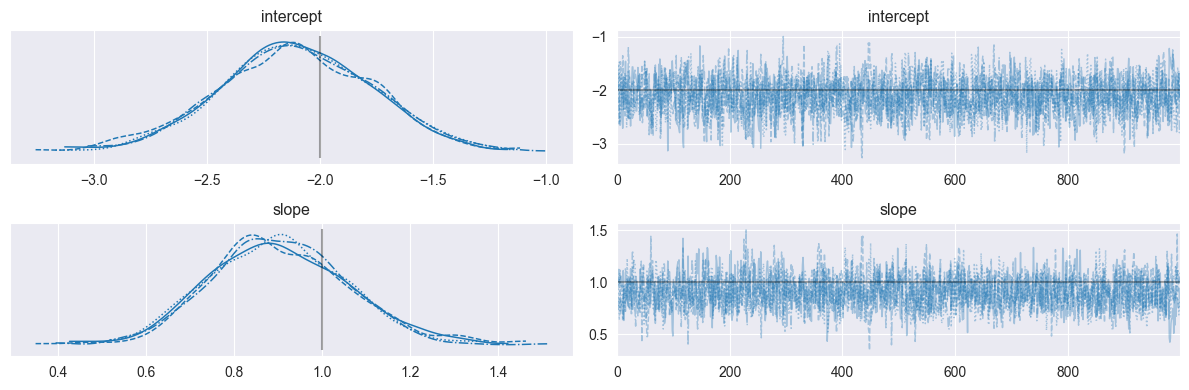

In [33]:
# Plot distribution & sampling chains
_ = az.plot_trace(
    informative_posterior,
    lines = (
        ("intercept", {}, true_intercept),
        ("slope", {}, true_slope)
    )
)

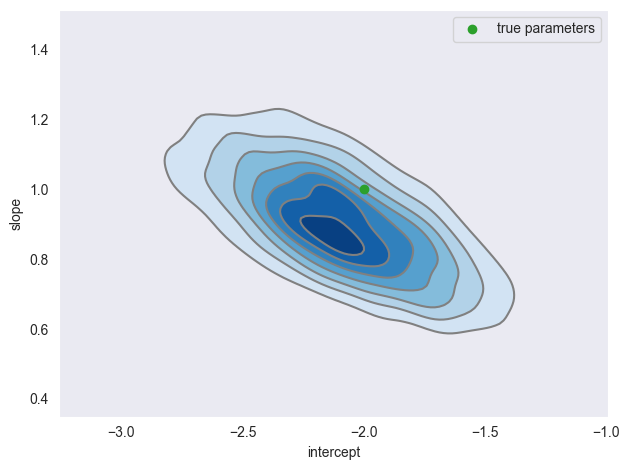

In [34]:
# Parameter space plot
_ = az.plot_kde(
    az.extract(informative_posterior, var_names="intercept"),
    az.extract(informative_posterior, var_names="slope"),
    contourf_kwargs={"cmap": "Blues"}
)
_ = plt.plot(true_intercept, true_slope, "C2o", label="true parameters")
_ = plt.xlabel("intercept")
_ = plt.ylabel("slope")
_ = plt.legend()

Comparable parameter estimates to frequentist logistic.

In [35]:
# Simulate fitted regression lines
informative_posterior.posterior["fitted"] = expit(informative_posterior.posterior["intercept"] + informative_posterior.posterior["slope"] * xarray)

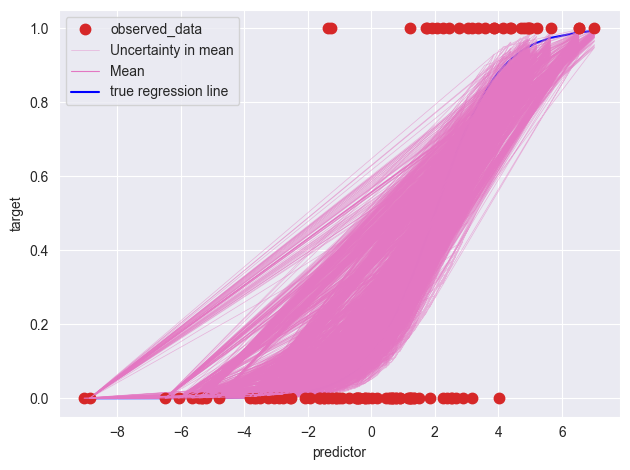

In [36]:
# Plot regression lines
_ = az.plot_lm(
    idata = informative_posterior, 
    x = x, # Predictor values
    y = y, # Real target
    y_model = "fitted" # Fitted regression lines
)
_ = sns.lineplot(
    x = x, 
    y = true_probs, 
    label = "true regression line", color = "blue")
_ = plt.xlabel("predictor")
_ = plt.ylabel("target")

C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\lib\site-packages\xarray\core\utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


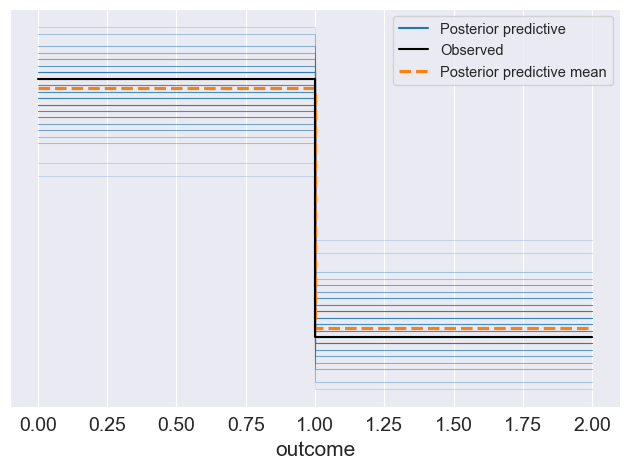

In [37]:
# Plot posterior distribution
_ = az.plot_ppc(informative_posterior, num_pp_samples = 100)

A supposedly "informative" prior is not much better than a flat prior. The "informative" prior likely needs to be much more restrictive to be useful with this little data.